In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import re
import requests
import pandas as pd
import numpy as np
from time import sleep
from bs4 import BeautifulSoup
import json


Datasets:


Victims of fatal encounters with the police, from mappingpoliceviolence.org (MPV), that includes similar features and information to the Washington Post dataset, but additionally lists the police department involved and includes fatal encounters where the cause of death was not shooting. 

The election 2016 demographic data that we analyzed in HW1 (we may replace this with official cenus data, but for an initial exploratory data analysis this dataste is clean and we are somewhat familiar with it)

LEMAS police department survey (). This includes a wide variety of information on the demographics and policies of individual police deparments. 



In [6]:
xls = pd.ExcelFile('data/MPVDatasetDownload_CleanColumnNames.xlsx')
#ew is event-wise 
df = pd.read_excel(xls, sheet_name='2013-2020 Police Killings')
killings_by_pd = pd.read_excel(xls,sheet_name='2013-2019 Killings by PD')
killings_by_state = pd.read_excel(xls,sheet_name='2013-2019 Killings by State')

df.head()

,victim_name,victim_age,victim_gender,victim_race,image_of_victim,date,street_address,city,state_code,zipcode,...,armed,weapon,threat_level,fleeing,body_camera,wapo_id,off_duty,geography,MPV_ID,fatal_encounters_id
0,Bennie Biby,44,Male,Unknown race,NaN,2020-10-28,NaN,Trigg County,KY,NaN,...,Allegedly Armed,undetermined,undetermined,NaN,No,6271.0,NaN,NaN,NaN,NaN
1,Clifton Gorman Spencer,35,Male,Unknown race,NaN,2020-10-27,NaN,Chattanooga,TN,NaN,...,Allegedly Armed,gun,other,NaN,No,6269.0,NaN,NaN,NaN,NaN
2,Name withheld by police,NaN,Male,Unknown race,NaN,2020-10-27,5300 W. Solafax Lane,Herriman,UT,84096.0,...,Allegedly Armed,undetermined,undetermined,NaN,No,6268.0,NaN,Suburban,NaN,NaN
3,Michael K. Nelson,27,Male,Unknown race,NaN,2020-10-26,NaN,Alexandria,VA,NaN,...,Allegedly Armed,gun,attack,foot,No,6270.0,NaN,NaN,NaN,NaN
4,Walter Wallace Jr.,27,Male,Black,NaN,2020-10-26,NaN,Philadelphia,PA,NaN,...,Allegedly Armed,knife,other,not fleeing,No,6266.0,NaN,NaN,NaN,NaN


In [7]:
# convert the date to datetime
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))


In [56]:
ages = pd.to_numeric(df.victim_age,errors='coerce')
ages = ages.dropna()
ages.values

array([44., 35., 27., ..., 49., 21., 26.])

In [117]:
(df.armed=='Allegedly Armed').mul(1).sum()

6116

In [118]:
def get_victim_stats(df):
    
    # takes in MPV dataframe and returns stats computed on select columns
    
    n = df.shape[0]
    
    vic_stats = {'n_victims': n}
    
    vic_stats['n_victims'] = n
    vic_stats['n_unarmed'] = (df.armed=='Unarmed/Did Not Have an Actual Weapon').mul(1).sum()
    vic_stats['n_armed'] = (df.armed=='Allegedly Armed').mul(1).sum()
    vic_stats['n_white'] = (df.victim_race=='White').mul(1).sum()
    vic_stats['n_black'] = (df.victim_race=='Black').mul(1).sum()
    vic_stats['n_hispanic'] = (df.victim_race=='Hispanic').mul(1).sum()
    
    ages = pd.to_numeric(df.victim_age,errors='coerce')
    ages = ages.dropna().values
    vic_stats['mean_age'] = np.mean(ages)
    
    vic_stats['frac_unarmed'] = vic_stats['n_unarmed']/n
    vic_stats['frac_white'] = vic_stats['n_white']/n
    vic_stats['frac_black'] = vic_stats['n_black']/n
    vic_stats['frac_hispanic'] = vic_stats['n_hispanic']/n
        
    return vic_stats
    


In [214]:
# load WaPo


# df demo
df_demo = pd.read_csv('data/acs2015_county_data.csv')


# load election data
df_election = pd.read_csv('data/election2016_by_county.csv')


# load LEMAS

lemas_raw = pd.read_csv('data/LEMAS_2016.tsv', sep = '\t', index_col = 'LEAR_ID', header = 0, encoding = 'unicode_escape')


race_fields = ['WHITE','BLACK','HISP','AMIND','ASIAN','HAWPI','MULTI','UNK']
gender_fields = ['MALE','FEM']

# remove rows that do not have demographic info
lemas_raw = lemas_raw.loc[(lemas_raw.PERS_MALE>=0) & (lemas_raw.PERS_FEMALE>=0) & (lemas_raw.PERS_WHITE_FEM>=0) & (lemas_raw.PERS_WHITE_MALE>=0)]


lemas_raw['PERS_TOTAL'] = lemas_raw.PERS_MALE + lemas_raw.PERS_FEMALE

# for now, take a fraction of the columns or it is overwhelming...
# EDIT:
lemas_new = lemas_raw.iloc[:,0:10]



lemas_new['PERS_TOTAL'] = lemas_raw.PERS_MALE + lemas_raw.PERS_FEMALE
lemas_new['PERS_WHITE'] = lemas_raw.PERS_WHITE_MALE + lemas_raw.PERS_WHITE_FEM
lemas_new['FRAC_WHITE'] = lemas_new.PERS_WHITE/lemas_new.PERS_TOTAL

# create FIPS code column for merging
df_demo['FIPS'] = df_demo.CensusId
df_election['FIPS'] = df_election.fipscode
df_election = df_election[['FIPS','trump','clinton','votergap','density']]

# make LEMAS FIPS CODE NUMERIC
lemas_new.FIPS = pd.to_numeric(lemas_new.FIPS,errors='coerce')
lemas_new = lemas_new.dropna()

# REMOVE STATE AGENCIES FOR NOW BECAUSE DEMOGRAPHICS HAVE NOT BEEN COMPUTED ON STATE-WIDE LEVEL
# Also, only 18 state agencies have had shooting victims, and count is relatively low, so we are not excluding a huge amount of useful data

lemas_new = lemas_new[lemas_new.AGENCYTYPE<3]

# merge county-level voter and demographic data into lemas new

lemas_new = lemas_new.merge(df_demo,how='left',on='FIPS')
lemas_new = lemas_new.merge(df_election,how='left',on='FIPS')

# for every police department, compute victim stats

vic_stats_all = []

for ind,row in lemas_new.iterrows():
    ori_id = row['ORI9']
    # find victims
    vic = df[df.ORI_agency_id==ori_id]
    vic_stats = get_victim_stats(vic)
    vic_stats['ORI9'] = ori_id
    vic_stats_all.append(vic_stats)

pd_vic_stats = pd.DataFrame(vic_stats_all)

lemas_new = lemas_new.merge(pd_vic_stats,how='left',on='ORI9')

C:\Users\Noah Petit\.conda\envs\cs109a\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Noah Petit\.conda\envs\cs109a\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Noah Petit\.conda\envs\cs109a\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\Noah Petit\.conda\envs\cs109a\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\Noah Petit\.conda\envs\cs109a\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in longlong_scalars


In [215]:

lemas_new

,AGENCYNAME,CITY,ZIPCODE,STATE,COUNTY,FIPS,ORI9,POPSERVED,POPGROUP,AGENCYTYPE,...,n_victims,n_unarmed,n_armed,n_white,n_black,n_hispanic,mean_age,frac_unarmed,frac_white,frac_black
0,DAVIS POLICE DEPARTMENT,DAVIS,95618,CA,YOLO,6113.0,CA0570100,68111,5,1,...,1,0,1,1,0,0,29.000000,0.000000,1.000000,0.000000
1,WEST NEW YORK POLICE,WEST NEW YORK,7093,NJ,HUDSON,34017.0,NJ0091200,53343,5,1,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,WESTOVER POLICE DEPARTMENT,WESTOVER,26501,WV,MONONGALIA,54061.0,WV0310400,4243,8,1,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
3,BARABOO POLICE DEPARTMENT,BARABOO,53913,WI,SAUK,55111.0,WI0570200,12173,7,1,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
4,OREGON POLICE DEPARTMENT,OREGON,53575,WI,DANE,55025.0,WI0137400,3334,8,1,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579,LAS VEGAS METRO POLICE DEPARTMENT,LAS VEGAS,89106,NV,CLARK,32003.0,NV0020100,1592178,1,1,...,68,8,57,31,13,16,36.676923,0.117647,0.455882,0.191176
2580,LOS ANGELES COUNTY SHERIFF'S DEPARTMENT,MONTEREY PARK,91754,CA,LOS ANGELES,6037.0,CA0190000,10137915,1,2,...,106,22,65,17,27,58,35.343137,0.207547,0.160377,0.254717
2581,CHICAGO POLICE DEPARTMENT,CHICAGO,60653,IL,COOK,17031.0,ILCPD0000,2704958,1,1,...,82,10,58,2,58,15,29.913580,0.121951,0.024390,0.707317
2582,LOS ANGELES POLICE DEPARTMENT,LOS ANGELES,90012,CA,,6037.0,CA0194200,3976322,1,1,...,132,19,103,20,27,76,34.895161,0.143939,0.151515,0.204545


In [125]:
# look at stats for only police departments with at least one shooting / killing
pd_vic_stats[pd_vic_stats.n_victims>0].describe()

,n_victims,n_unarmed,n_armed,n_white,n_black,n_hispanic,mean_age,frac_unarmed,frac_white,frac_black
count,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,835.000000,845.000000,845.000000,845.000000
mean,5.317160,0.786982,3.831953,1.867456,1.649704,1.080473,36.991276,0.145251,0.472927,0.249680
std,10.001244,1.739442,7.408377,2.758690,4.430922,4.121744,9.765704,0.260163,0.402016,0.341764
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,2.000000,1.000000,0.000000,0.000000,36.000000,0.000000,0.455882,0.000000
75%,5.000000,1.000000,4.000000,2.000000,1.000000,1.000000,41.333333,0.200000,1.000000,0.500000
max,132.000000,22.000000,103.000000,31.000000,58.000000,76.000000,76.000000,1.000000,1.000000,1.000000


In [130]:
(pd_vic_stats.n_victims>0).mul(1).mean()

0.32726568551510454

In [141]:
lemas_new[lemas_new.n_victims>=10].sort_values('frac_unarmed',ascending=False)

,AGENCYNAME,CITY,ZIPCODE,STATE,COUNTY,FIPS,ORI9,POPSERVED,POPGROUP,AGENCYTYPE,...,n_victims,n_unarmed,n_armed,n_white,n_black,n_hispanic,mean_age,frac_unarmed,frac_white,frac_black
562,CLEVELAND POLICE DEPARTMENT,CLEVELAND,44113,OH,CUYAHOGA,39035.0,OHCLP0000,385809,3,1,...,11,5,5,1,10,0,29.818182,0.454545,0.090909,0.909091
2589,PRINCE GEORGES COUNTY POLICE,HYATTSVILLE,20785,MD,PRINCE GEORGE'S,24033.0,MD0172100,693100,2,1,...,14,5,9,0,13,1,30.714286,0.357143,0.000000,0.928571
2610,SAN DIEGO COUNTY SHERIFF'S OFFICE,SAN DIEGO,92193,CA,SAN DIEGO,6073.0,CA0370000,3317749,1,2,...,20,7,10,6,2,10,37.722222,0.350000,0.300000,0.100000
2608,ATLANTA POLICE DEPARTMENT,ATLANTA,30303,GA,FULTON,13121.0,GAAPD0000,439856,3,1,...,18,6,10,1,16,0,29.764706,0.333333,0.055556,0.888889
2574,PASCO COUNTY SHERIFF'S OFFICE,NEW PORT RICHEY,34654,FL,PASCO,12101.0,FL0510000,512368,2,2,...,12,4,6,9,2,0,43.181818,0.333333,0.750000,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300,GLENDALE POLICE DEPARTMENT,GLENDALE,85301,AZ,MARICOPA,4013.0,AZ0071300,245895,4,1,...,11,0,11,5,2,4,31.727273,0.000000,0.454545,0.181818
2343,UNIFIED POLICE DEPARTMENT OF GREATER SALT LAKE,SALT LAKE CITY,84190,UT,SALT LAKE COUNTY,49035.0,UT0180000,1121354,1,2,...,12,0,11,7,2,1,36.666667,0.000000,0.583333,0.166667
2555,BREVARD COUNTY SHERIFF'S OFFICE,TITUSVILLE,32780,FL,BREVARD,12009.0,FL0050000,579130,2,2,...,11,0,9,4,4,1,36.800000,0.000000,0.363636,0.363636
2532,BOSTON POLICE DEPARTMENT,BOSTON,2120,MA,SUFFOLK,25025.0,MA0130100,673184,2,1,...,13,0,13,1,9,1,31.538462,0.000000,0.076923,0.692308


In [142]:
lemas_new[lemas_new.n_victims>=10].sort_values('n_unarmed',ascending=False)

,AGENCYNAME,CITY,ZIPCODE,STATE,COUNTY,FIPS,ORI9,POPSERVED,POPGROUP,AGENCYTYPE,...,n_victims,n_unarmed,n_armed,n_white,n_black,n_hispanic,mean_age,frac_unarmed,frac_white,frac_black
2620,LOS ANGELES COUNTY SHERIFF'S DEPARTMENT,MONTEREY PARK,91754,CA,LOS ANGELES,6037.0,CA0190000,10137915,1,2,...,106,22,65,17,27,58,35.343137,0.207547,0.160377,0.254717
2622,LOS ANGELES POLICE DEPARTMENT,LOS ANGELES,90012,CA,,6037.0,CA0194200,3976322,1,1,...,132,19,103,20,27,76,34.895161,0.143939,0.151515,0.204545
2623,NEW YORK CITY POLICE DEPARTMENT,NEW YORK,10038,NY,NEW YORK,36061.0,NY0303000,8537653,1,1,...,79,15,58,10,52,10,36.670886,0.189873,0.126582,0.658228
2603,JACKSONVILLE SHERIFF'S OFFICE,JACKSONVILLE,32202,FL,DUVAL,12031.0,FL0162400,926255,2,2,...,46,11,34,19,22,2,32.204545,0.239130,0.413043,0.478261
2621,CHICAGO POLICE DEPARTMENT,CHICAGO,60653,IL,COOK,17031.0,ILCPD0000,2704958,1,1,...,82,10,58,2,58,15,29.913580,0.121951,0.024390,0.707317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,BREVARD COUNTY SHERIFF'S OFFICE,TITUSVILLE,32780,FL,BREVARD,12009.0,FL0050000,579130,2,2,...,11,0,9,4,4,1,36.800000,0.000000,0.363636,0.363636
2300,GLENDALE POLICE DEPARTMENT,GLENDALE,85301,AZ,MARICOPA,4013.0,AZ0071300,245895,4,1,...,11,0,11,5,2,4,31.727273,0.000000,0.454545,0.181818
2447,SAINT PAUL POLICE DEPARTMENT,SAINT PAUL,55101,MN,RAMSEY,27123.0,MN0620900,302398,3,1,...,13,0,10,3,5,1,30.307692,0.000000,0.230769,0.384615
2343,UNIFIED POLICE DEPARTMENT OF GREATER SALT LAKE,SALT LAKE CITY,84190,UT,SALT LAKE COUNTY,49035.0,UT0180000,1121354,1,2,...,12,0,11,7,2,1,36.666667,0.000000,0.583333,0.166667


Text(0.5, 1.0, 'Each point is a police department responsible for at least 10 victims')

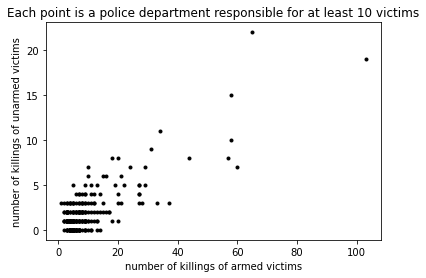

In [162]:
include = lemas_new.n_victims>=5

plt.plot(lemas_new.n_armed[include], lemas_new.n_unarmed[include],'k.')
plt.xlabel('number of killings of armed victims')
plt.ylabel('number of killings of unarmed victims')
plt.title('Each point is a police department responsible for at least 10 victims')

Text(0, 0.5, 'fraction killings of unarmed victims')

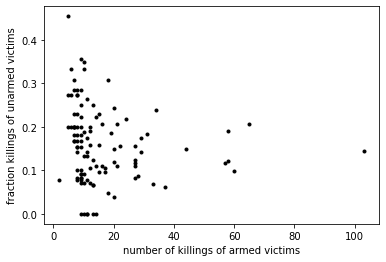

In [165]:
include = lemas_new.n_victims>=10

plt.plot(lemas_new.n_armed[include], lemas_new.frac_unarmed[include],'k.')
plt.xlabel('number of killings of armed victims')
plt.ylabel('fraction killings of unarmed victims')

Text(0, 0.5, 'fraction killings of victims who are unarmed')

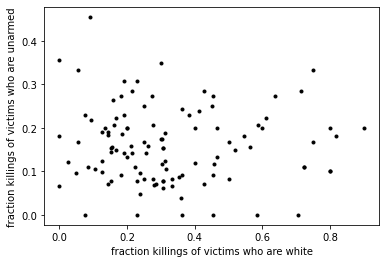

In [166]:
plt.plot(lemas_new.frac_white[include], lemas_new.frac_unarmed[include],'k.')
plt.xlabel('fraction killings of victims who are white')
plt.ylabel('fraction killings of victims who are unarmed')

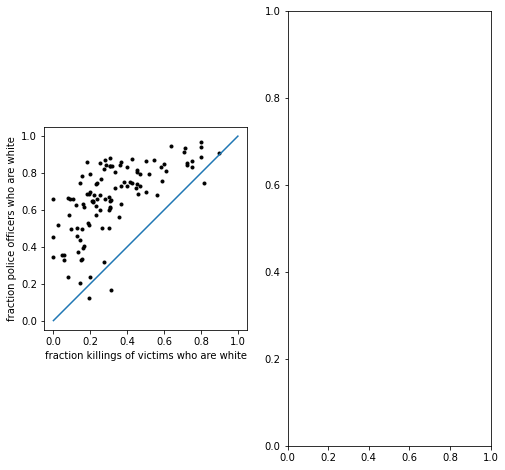

In [187]:
fig, ax = plt.subplots(1,2,figsize=(8, 8))
ax = ax.flatten()

ax[0].plot(lemas_new.frac_white[include], lemas_new.FRAC_WHITE[include],'k.')
ax[0].set(xlabel= 'fraction killings of victims who are white',ylabel='fraction police officers who are white', aspect='equal')
ax[0].plot([0,1],[0,1])




